<a href="https://colab.research.google.com/github/Sejal-Jamwal/Emotional-Lip-Reading--Sentiment-Analysis/blob/main/LipNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install and Import Dependencies

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import gdown

In [7]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=2cabb669-1979-4e68-b0dc-80031248de0c
To: /content/data.zip
100%|██████████| 423M/423M [00:04<00:00, 93.6MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [8]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [13]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [14]:
import shutil

In [15]:
import os
import shutil

# Define the source and destination folders
source_folder = '/content/data/alignments/s1'
destination_folder = '/content/data/s1'

# Iterate over the files in the source folder
for filename in os.listdir(source_folder):
    # Get the full path of the file
    source_file = os.path.join(source_folder, filename)
    # Check if it's a file (not a subdirectory)
    if os.path.isfile(source_file):
        # Copy the file to the destination folder
        shutil.copy(source_file, destination_folder)

In [16]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [17]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','s1',f'{file_name}.align') # /content/data/alignments/s1
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [18]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [19]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [20]:
!ls data/alignments/s1/bbal6n.align

data/alignments/s1/bbal6n.align


In [21]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

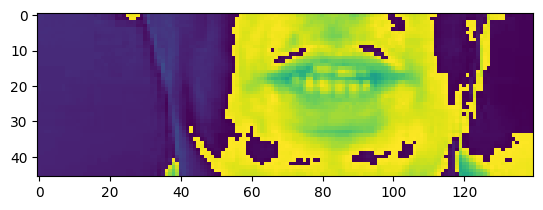

In [22]:
plt.imshow(frames[40])

In [23]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [24]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [25]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [26]:
from matplotlib import pyplot as plt

In [27]:
data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(100)
test = data.skip(450)

In [28]:
len(test)

50

In [29]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [30]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [31]:
iterator = data.as_numpy_iterator()
frames, alignments = iterator.next()

In [32]:
len(frames)

2

In [33]:
sample = data.as_numpy_iterator()

In [34]:
val = sample.next(); val[0]

array([[[[[1.4654757 ],
          [1.4654757 ],
          [1.4654757 ],
          ...,
          [0.        ],
          [0.03960745],
          [0.03960745]],

         [[1.4654757 ],
          [1.4654757 ],
          [1.4654757 ],
          ...,
          [0.        ],
          [0.03960745],
          [0.03960745]],

         [[1.3862609 ],
          [1.3862609 ],
          [1.3862609 ],
          ...,
          [0.11882236],
          [0.0792149 ],
          [0.0792149 ]],

         ...,

         [[0.9901863 ],
          [0.9901863 ],
          [0.9901863 ],
          ...,
          [9.94147   ],
          [9.901863  ],
          [9.901863  ]],

         [[0.9901863 ],
          [0.9901863 ],
          [0.9901863 ],
          ...,
          [9.901863  ],
          [9.862255  ],
          [9.862255  ]],

         [[0.9901863 ],
          [0.9901863 ],
          [0.9901863 ],
          ...,
          [9.901863  ],
          [9.862255  ],
          [9.862255  ]]],


        [[[1.4654

In [35]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay green in f two please'>

# 3. Design the Deep Neural Network

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [37]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [38]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [40]:
5*17*75

6375

In [41]:
yhat = model.predict(val[0])

1/1 [==============================] - 6s 6s/step


In [42]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'ccmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmsssss22222222222222222222222ttttttppp'>

In [43]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ccmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmsssss22222222222222222222222ttttttppp'>

In [44]:
model.input_shape

(None, 75, 46, 140, 1)

In [45]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [46]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [47]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [48]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [49]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1), loss=CTCLoss)

In [50]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [51]:
schedule_callback = LearningRateScheduler(scheduler)

In [52]:
example_callback = ProduceExample(test)

In [53]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

1/1 [==============================] - 2s 2s/step
Original: lay blue at q six please
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green with x two now
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
100/100 [==============================] - 579s 6s/step - loss: 369.2318 - val_loss: 365.3666 - lr: 0.1000


# 5. Make a Prediction

In [54]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=a7514b40-06ca-44a6-9201-1cd894c3136c
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 169MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [55]:
model.load_weights('models/checkpoint')

In [56]:
test_data = test.as_numpy_iterator()

In [57]:
sample = test_data.next()

In [58]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 273ms/step


In [59]:
print('~'*100, 'REAL TEXT')
res_str = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


In [60]:

decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [61]:
print(decoded)

[[ 2  9 14 39  2 12 21  5 39  2 25 39 13 39 26  5 18 15 39 14 15 23  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1]
 [16 12  1  3  5 39  2 12 21  5 39  1 20 39  3 39 20 23 15 39 16 12  5  1
  19  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1]]


In [62]:
print('~'*100, 'PREDICTIONS')
strings = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
frames_ = []
for s in strings:
  string_value = s.numpy().decode('utf-8')
  frames_.append(string_value)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


# Test on a Video

In [63]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [115]:
print('~'*100, 'REAL TEXT')

arr = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]
frames_ = []
for s in arr:
  string_value = s.numpy().decode('utf-8')
  frames_.append(string_value)
print(frames_)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
['bin red at s nine again']


In [65]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [66]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [67]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [68]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [70]:
df = pd.read_csv('smile-annotations-final.csv', names=['id', 'text', 'category'])
df.set_index('id', inplace=True)

In [71]:
df.head()

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [72]:
df = df[~df.category.str.contains('\|')]

In [73]:
df = df[df.category != 'nocode']

In [74]:
possible_labels = df.category.unique()

In [75]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [76]:
df['label'] = df.category.replace(label_dict)

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size=0.15,
                                                  random_state=17,
                                                  stratify=df.label.values)

In [79]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [80]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [81]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [82]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [83]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [84]:
from transformers import BertForSequenceClassification

In [85]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [87]:
batch_size = 32

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [88]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [89]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [90]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [91]:
import numpy as np

In [92]:
from sklearn.metrics import f1_score

In [93]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [94]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [95]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [97]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [98]:
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.1190530806779861
Validation loss: 0.8579910738127572
F1 Score (Weighted): 0.6656119824269878


Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7923506833612919
Validation loss: 0.748667299747467
F1 Score (Weighted): 0.7043271626231267


Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6922417253255844
Validation loss: 0.7199711373874119
F1 Score (Weighted): 0.7241501484452205


In [99]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [126]:
file_name = input("Enter File Name: ")
sample = load_data(tf.convert_to_tensor(file_name))
arr = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]
frames_ = []
for s in arr:
  string_value = s.numpy().decode('utf-8')
  frames_.append(string_value)

Enter File Name: /content/data/s1/bbaf2n.mpg


In [100]:
model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_2.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [101]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [102]:
accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy: 171/171

Class: not-relevant
Accuracy: 4/32

Class: angry
Accuracy: 0/9

Class: disgust
Accuracy: 0/1

Class: sad
Accuracy: 0/5

Class: surprise
Accuracy: 0/5



In [127]:
def predict_sentiment(model, tokenizer, sentence):
  encoded_data = tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      return_attention_mask=True,
      pad_to_max_length=True,
      max_length=256,
      return_tensors='pt'
  )


  input_ids = encoded_data['input_ids'].to(device)
  attention_masks = encoded_data['attention_mask'].to(device)

  model.eval()
  with torch.no_grad():
      outputs = model(input_ids, attention_mask=attention_masks)

  logits = outputs[0]
  _, predicted = torch.max(logits.data, 1)
  label_dict = {"LABEL_0": 0, "LABEL_1": 1, "LABEL_1": 2}
  label_dict_inverse = {v: k for k, v in label_dict.items()}
  predicted_label = label_dict_inverse[predicted.item()]
  if predicted_label == "LABEL_0":
    return "Neutral"
  if predicted_label == "LABEL_1":
    return "Happy"
  if predicted_label == "LABEL_2":
    return "Sad"

print('~'*100, 'PREDICTIONS')
strings = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
predicted_label = predict_sentiment(model, tokenizer, frames_[0])
print(f'Predicted label for "{file_name}": {predicted_label}')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
Predicted label for "/content/data/s1/bbaf2n.mpg": Neutral
